In [32]:
# ---- 1. Imports ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [34]:
# ---- 2. Load the data ----
# Change the file name below if your dataset file is different
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Preview data
print("Rows:", df.shape[0], "| Columns:", df.shape[1])
display(df.head())


Rows: 7043 | Columns: 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [35]:
# ---- 3. Clean & encode Churn column ----
# Try common churn column names/cases
for col in df.columns:
    if col.lower() == 'churn':
        churn_col = col
        break
else:
    raise Exception("No column named 'Churn' found. Please check column names.")

# Standardize Churn encoding
if df[churn_col].dtype == object:
    # Clean up string labels
    df[churn_col] = df[churn_col].astype(str).str.strip().str.title()
    if set(df[churn_col].unique()) >= {'Yes', 'No'}:
        df = df[df[churn_col].isin(['Yes', 'No'])].copy()
        df[churn_col] = df[churn_col].map({'No': 0, 'Yes': 1})
    elif set(df[churn_col].unique()) >= {'1', '0'}:
        df[churn_col] = df[churn_col].astype(int)
    else:
        print('Unique values in Churn:', df[churn_col].unique())
        raise Exception("Churn column must have 'Yes'/'No' or 1/0 labels.")
elif df[churn_col].dtype in [np.int64, np.float64]:
    df[churn_col] = df[churn_col].fillna(-1).astype(int)
    df = df[df[churn_col].isin([0,1])]
else:
    print('Churn dtype:', df[churn_col].dtype)
    raise Exception("Unknown Churn column type.")

In [36]:
# ---- 4. Key Numeric Clean-up (for Telco, 'TotalCharges' is often object/string) ----
for col in ['TotalCharges', 'MonthlyCharges','tenure']:
    if col in df.columns and df[col].dtype == object:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with missing Churn, tenure, or charges
keep_cols = [churn_col] + [c for c in ['tenure', 'MonthlyCharges', 'TotalCharges'] if c in df.columns]
df = df.dropna(subset=keep_cols).copy()

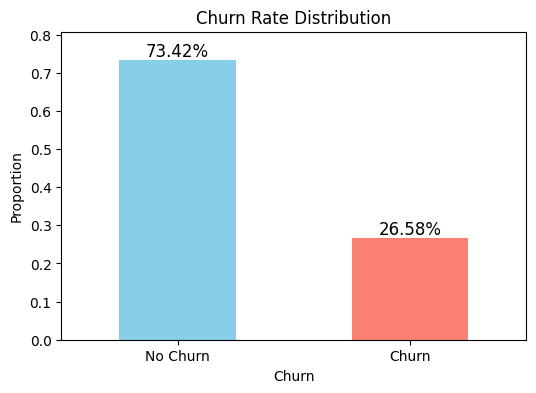

In [37]:
# ---- 5. Target Churn Distribution ----
plt.figure(figsize=(6,4))
churn_distribution = df[churn_col].value_counts(normalize=True).sort_index()
ax = churn_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Rate Distribution')
plt.xticks([0,1], ['No Churn', 'Churn'], rotation=0)
plt.ylabel('Proportion')
for i, p in enumerate(ax.patches):
    percentage = churn_distribution[i] * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width()/2, p.get_height() + 0.01), ha='center', fontsize=12)
plt.ylim(0, 1.1 * churn_distribution.max())
plt.show()

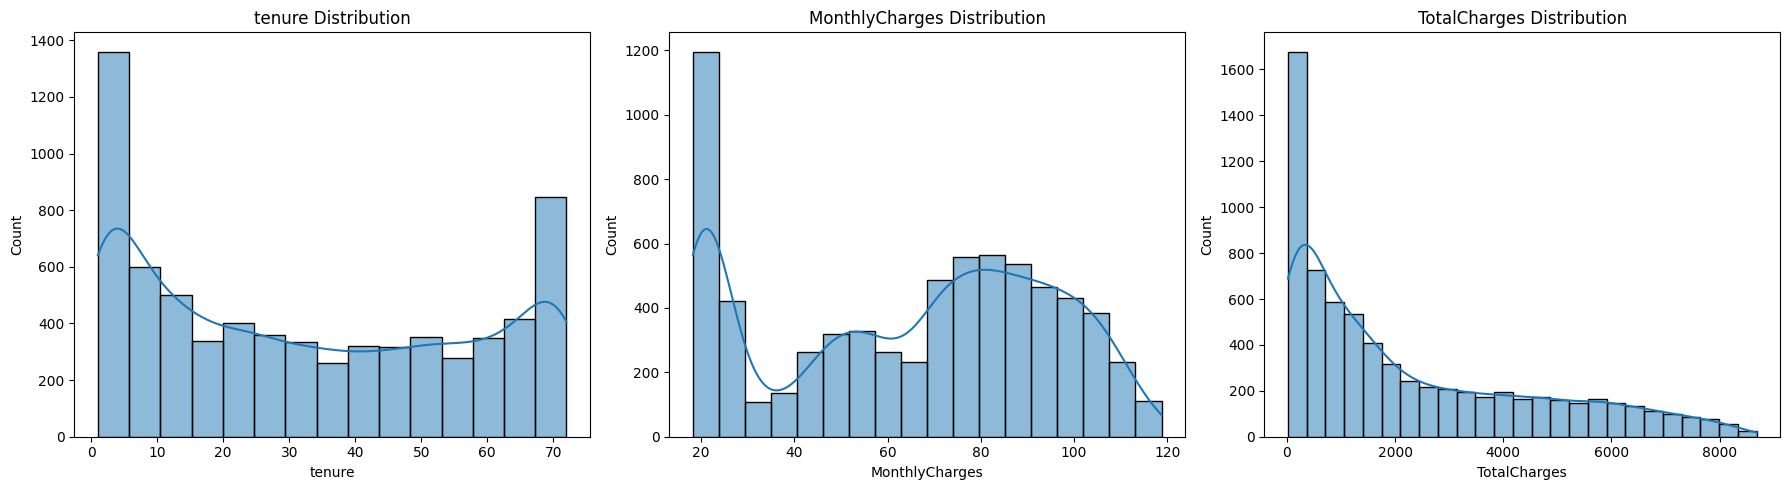

In [38]:
# ---- 6. Numeric Univariate Analysis ----
num_feats = [c for c in ['tenure', 'MonthlyCharges', 'TotalCharges'] if c in df.columns]
fig, axes = plt.subplots(1, len(num_feats), figsize=(6*len(num_feats),5))
if len(num_feats)==1: axes = [axes]
for idx, col in enumerate(num_feats):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution')
plt.tight_layout()
plt.show()

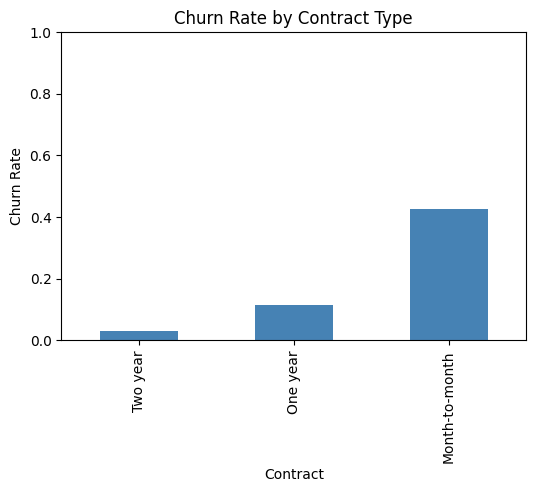

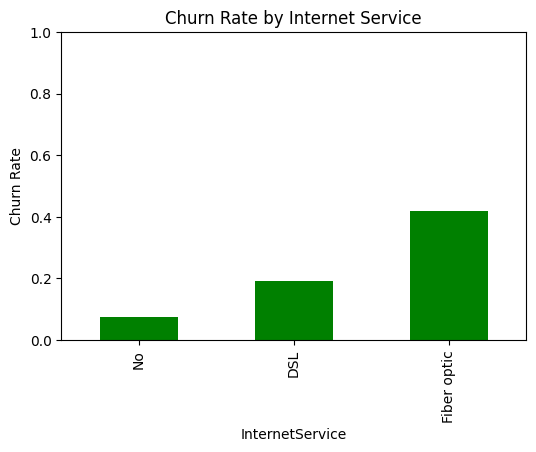

In [39]:
# ---- 7. Churn by major category ----
for feature, color, title in [('Contract','steelblue','Churn Rate by Contract Type'),
                              ('InternetService','green','Churn Rate by Internet Service')]:
    if feature in df.columns:
        plt.figure(figsize=(6,4))
        y = df.groupby(feature)[churn_col].mean().sort_values()
        y.plot(kind='bar', color=color)
        plt.title(title)
        plt.ylabel('Churn Rate')
        plt.ylim(0, 1)
        plt.show()

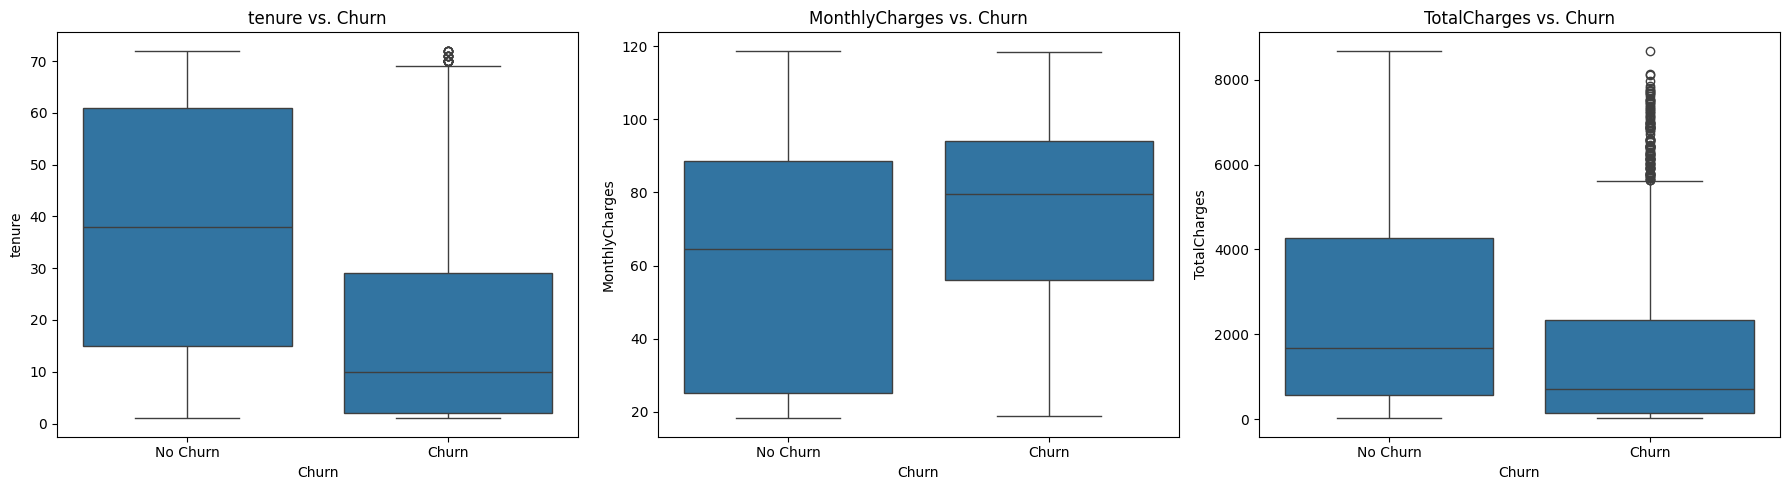

In [40]:
# ---- 8. Numeric Features vs Churn (Boxplots) ----
fig, axes = plt.subplots(1, len(num_feats), figsize=(6*len(num_feats),5))
if len(num_feats)==1: axes = [axes]
for idx, feature in enumerate(num_feats):
    sns.boxplot(x=churn_col, y=feature, data=df, ax=axes[idx])
    axes[idx].set_xticklabels(['No Churn', 'Churn'])
    axes[idx].set_title(f'{feature} vs. Churn')
plt.tight_layout()
plt.show()

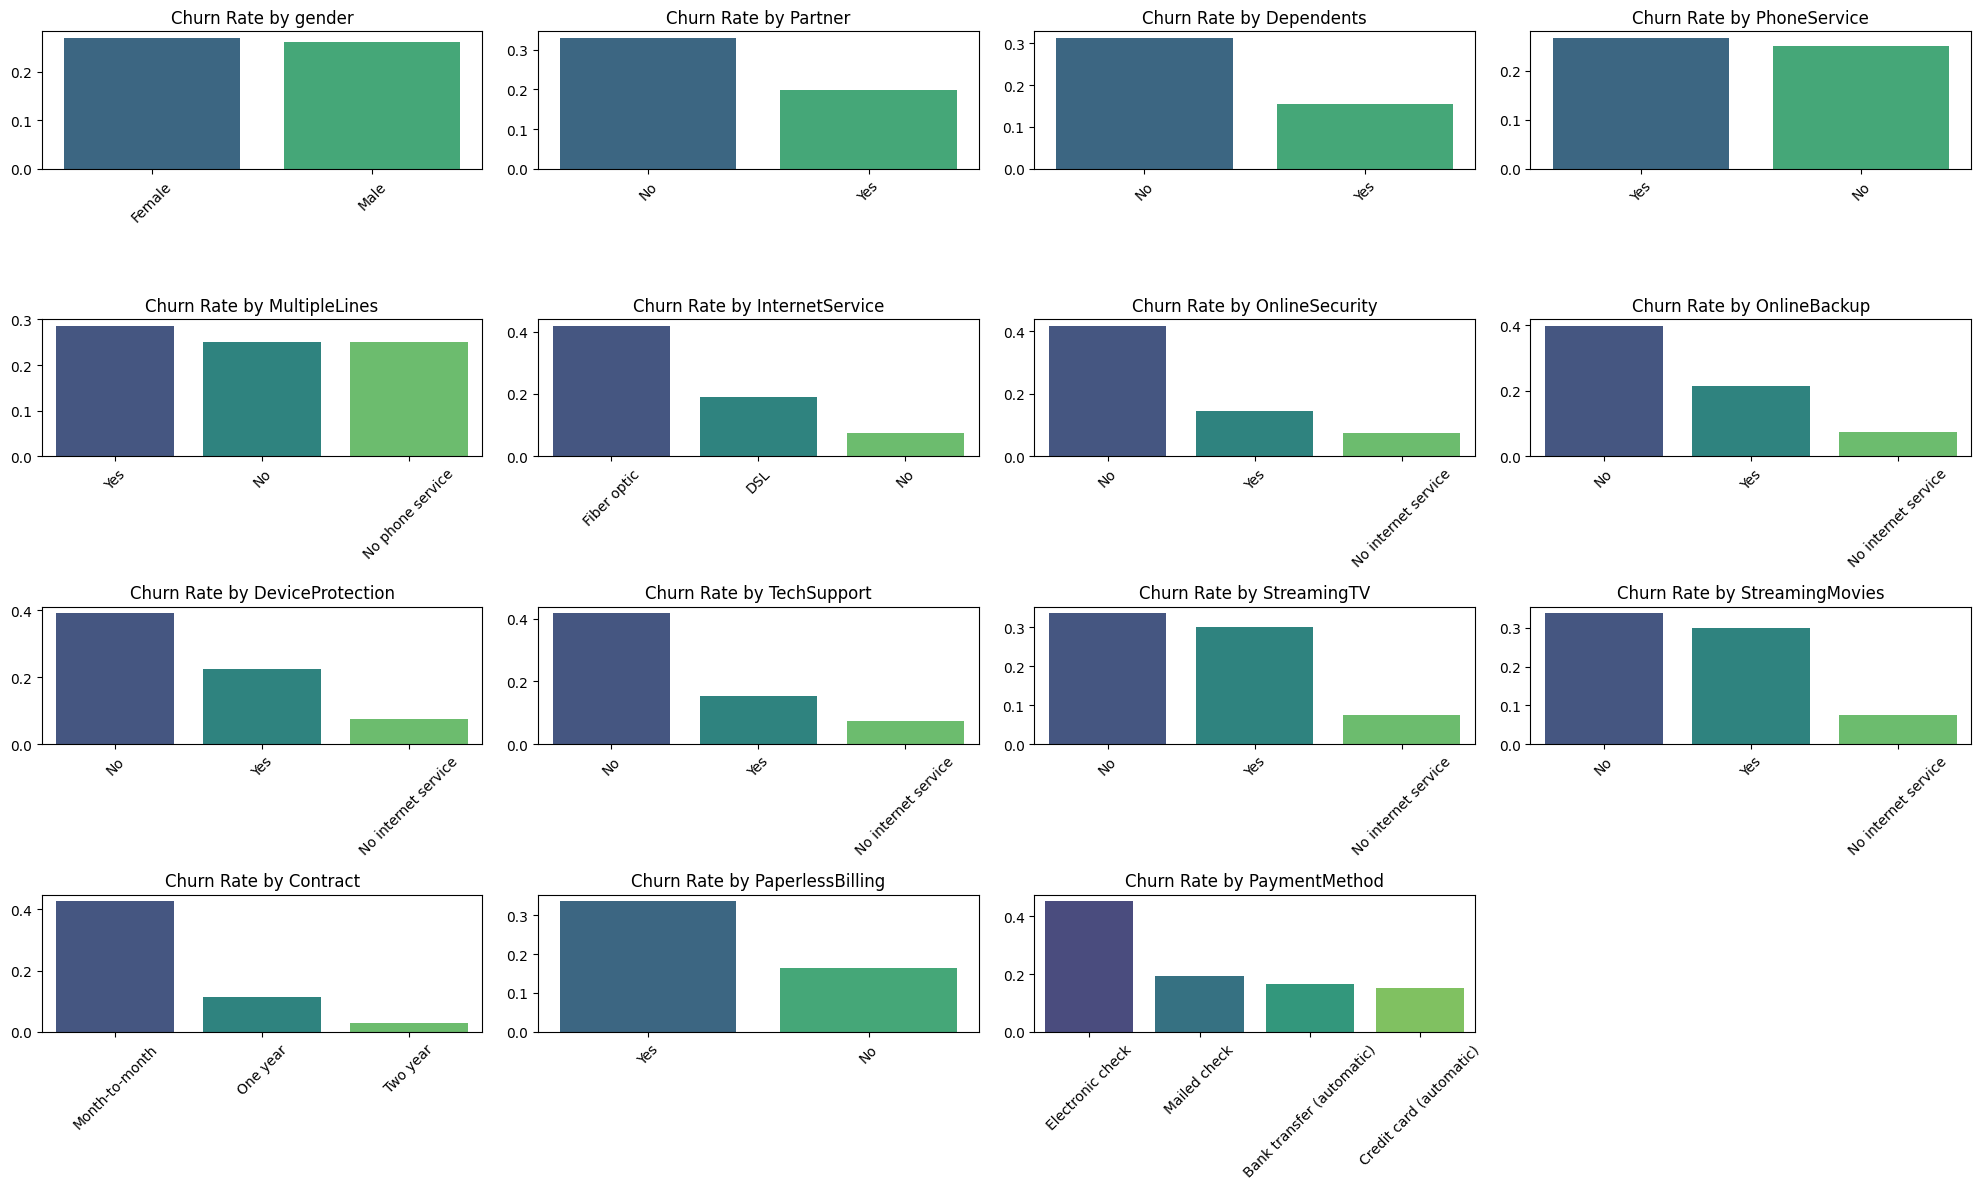

In [41]:
# ---- 9. Categorical Features vs Churn ----
all_cat = df.select_dtypes(include='object').columns.tolist() + df.select_dtypes(include='category').columns.tolist()
cat_features = [c for c in all_cat if c not in [churn_col, 'customerID','CustomerID','customer_id','Phone','phone number']]
cat_features = [c for c in cat_features if df[c].nunique()<20 and df[c].nunique()>1]
ncols = 4
nrows = int(np.ceil(len(cat_features)/ncols))
plt.figure(figsize=(ncols*5, max(3,nrows*3)))
for i, col in enumerate(cat_features, 1):
    plt.subplot(nrows, ncols, i)
    churn_rates = df.groupby(col)[churn_col].mean().sort_values(ascending=False)
    sns.barplot(x=churn_rates.index.astype(str), y=churn_rates.values, palette='viridis')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

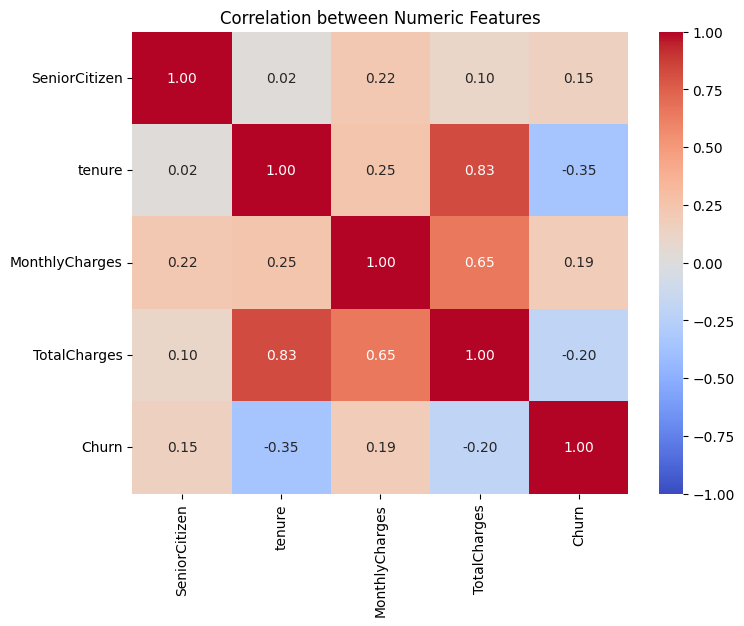

In [42]:
# ---- 10. Correlation Heatmap ----
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation between Numeric Features")
plt.show()

In [43]:
# ---- 11. Outlier Detection ----
key_numerics = [c for c in ['MonthlyCharges','TotalCharges','tenure'] if c in numeric_df.columns]
outlier_df = df[key_numerics].dropna()
if not outlier_df.empty:
    outliers = (np.abs(zscore(outlier_df)) > 3).sum(axis=0)
    print("Potential outlier counts for major numeric features:", dict(zip(key_numerics, outliers)))
else:
    print("Not enough data for outlier analysis on numeric features.")

print("\n--- Finished Exploratory Analysis ---")

Potential outlier counts for major numeric features: {'MonthlyCharges': np.int64(0), 'TotalCharges': np.int64(0), 'tenure': np.int64(0)}

--- Finished Exploratory Analysis ---
